In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns

import scanpy as sc
import scanpy.external as sce
import anndata as ad

import session_info
import warnings
from pyprojroot.here import here

import scienceplots
from sklearn.neighbors import NearestNeighbors
from typing import Iterable
import pickle
from matplotlib.backends.backend_pdf import PdfPages


# Setting some parameters
warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

# Import custom functions
from customPythonFunctions import *

print("Main directory path: {}".format(here()))

plt.style.use(['nature'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

Main directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas


**Setting parameters** 

In [2]:
overwriteFigures = True
overwriteData = True

In [3]:
cellGroup = 'RBC_and_HSC'
workDir = os.getcwd()

**Load data**

In [4]:
# Load the scvi h5ad file
adata = sc.read_h5ad(here("{}/results/03_{}_scVI_UMAP_clinical_allGenes.h5ad".format(workDir, cellGroup)))
adata.uns['log1p'] = dict()
adata.uns['log1p']['base'] = None # only if logscale is computed
adata

AnnData object with n_obs × n_vars = 12028 × 22838
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'doublet_score', 'predicted_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable'
    uns: '_scvi_m

**Loading gene dictionary**

In [5]:
with open(here('external_reference_data/markerGenes_dictionary.pkl'), 'rb') as f:
    marker_genes_dict = pickle.load(f)

In [6]:
canonical_marker_gene_list = [g for g in marker_genes_dict['lineages'].values() for g in g if g in adata.var.symbol.values]

if cellGroup in marker_genes_dict:
    lineage_marker_gene_list = set([g for g in marker_genes_dict[cellGroup].values() for g in g if g in adata.var.symbol.values])
else: 
    lineage_marker_gene_list = None

**Plotting parameters** 

In [7]:
max_cells_plot = 200000
fraction = min(1, (max_cells_plot/adata.shape[0]))

**Loading clustering resolutions** 

In [8]:
clusterDF_path = here('{}/results/INFLAMMATION_clustering_resolutions_to_explore.pkl'.format(workDir))
clusterDF = pd.read_pickle(clusterDF_path)
clusterDF.head()

,leiden_res_0.1,leiden_res_0.25,leiden_res_0.5,leiden_res_0.75,leiden_res_1
cellID,,,,,
SCGT00_L051_I55.3P_T0_AGACTCAGTTTACTGG,3,3,4,3,3
SCGT00_L051_I52.3P_T0_ATACCGACAGACAAGC,0,0,0,0,0
SCGT00_L051_I58.3P_T0_CATTCATTCCTATGGA,0,0,0,0,0
SCGT00_L051_I52.3P_T0_CCGATCTTCAGACCCG,3,3,4,3,3
SCGT00_L051_I58.3P_T0_CTCAAGAGTCTTCGAA,0,0,1,1,1


In [9]:
# Merging cluster resolutions with adata object

adata_obs_df = adata.obs.merge(clusterDF, left_index=True, right_index=True, how='left')
adata.obs = adata_obs_df
adata.obs.head()

,studyID,libraryID,sampleID,chemistry,technology,patientID,disease,timepoint_replicate,treatmentStatus,therapyResponse,...,doublet_score,predicted_doublet,S_score,G2M_score,phase,leiden_res_0.1,leiden_res_0.25,leiden_res_0.5,leiden_res_0.75,leiden_res_1
cellID,,,,,,,,,,,,,,,,,,,,,
SCGT00_L051_I55.3P_T0_AGACTCAGTTTACTGG,SCGT00,SCGT00_L051,SCGT00_I55.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I55,RA,0.0,ongoing,R,...,0.043,0,-0.030178,-0.069435,G1,3,3,4,3,3
SCGT00_L051_I52.3P_T0_ATACCGACAGACAAGC,SCGT00,SCGT00_L051,SCGT00_I52.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I52,RA,0.0,ongoing,NR,...,0.030,0,-0.036518,-0.065312,G1,0,0,0,0,0
SCGT00_L051_I58.3P_T0_CATTCATTCCTATGGA,SCGT00,SCGT00_L051,SCGT00_I58.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I58,RA,0.0,ongoing,NR,...,0.037,0,-0.004612,-0.034372,G1,0,0,0,0,0
SCGT00_L051_I52.3P_T0_CCGATCTTCAGACCCG,SCGT00,SCGT00_L051,SCGT00_I52.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I52,RA,0.0,ongoing,NR,...,0.024,0,-0.031262,-0.063023,G1,3,3,4,3,3
SCGT00_L051_I58.3P_T0_CTCAAGAGTCTTCGAA,SCGT00,SCGT00_L051,SCGT00_I58.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I58,RA,0.0,ongoing,NR,...,0.076,0,-0.041559,-0.065553,G1,0,0,1,1,1


# Cluster annotation

In [10]:
# Establishing the resolution of choice
resolution_of_choice = 0.1
leiden_cluster = "leiden_res_" + str(resolution_of_choice)
de_key = "de_res_" + str(resolution_of_choice)

In [11]:
annotation_column_name = "annotation_step_1"

In [12]:
# Dictionary to map cluster to annotation label
cluster2annotation_lineages = {
     '0': 'HSC',
     '1': 'Mono',
     '2': 'HSC',
     '3': 'Doublets_Step1', # RBC + T cells
     '4': 'Doublets_Step1', # RBC + Myeloid cells
     '5': 'RBC',
     '6': 'LowQuality_cells'
     # (...)
}

# Add a new `.obs` column called `annotation_column_name` by mapping clusters to annotation using pandas `map` function
adata.obs[annotation_column_name] = adata.obs[leiden_cluster].map(cluster2annotation_lineages).astype('category')

**Checking clustering annotation**

In [13]:
# List of all annotated cell types
print(set(adata.obs[annotation_column_name]))

# Confirm all cells got their assigment
if ("" in set(adata.obs[annotation_column_name])):
    print("Error: not all cells were assigned a lineage")
else:
    print("All cells were assigned a lineage!")

{'Mono', 'HSC', 'RBC', 'LowQuality_cells', 'Doublets_Step1'}
All cells were assigned a lineage!


## Visualize annotation results

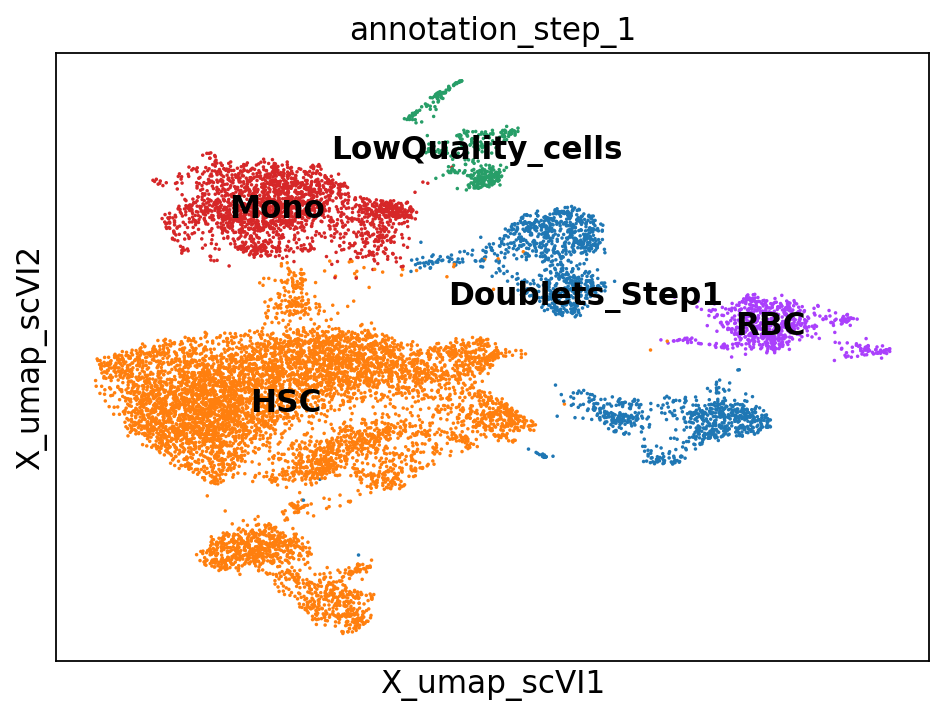

In [14]:
# Subsetting and randomizing for optimal plotting
random_indices = balanced_sample(adata.obs, cols = annotation_column_name, frac = fraction, shuffle = True, random_state = 42).cellID

sc.set_figure_params(figsize=(7, 5))
fig = sc.pl.embedding(adata[random_indices, :], basis="X_umap_scVI", color=annotation_column_name, 
                      use_raw=False, show=True, return_fig=True, size=10, legend_loc="on data")

if overwriteFigures:
    plt.savefig(here('{}/results/figures/UMAP_clusters_res{}_annotated.pdf'.format(workDir, resolution_of_choice)), 
                bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

## Export cluster annotation

In [15]:
clusterAnnotDF = pd.DataFrame(adata.obs[annotation_column_name])
# Save annotation as DF
clusterAnnotDF.to_pickle(path=here('{}/results/INFLAMMATION_cluster_res{}_annotated.pkl'.format(workDir, resolution_of_choice)))

In [16]:
session_info.show()